Data Cleaning
---

This notebook is dedicated to checking and cleaning the contents of the split-belt database.

** Methods **
- Remove data that is missing relavent features and target data
- Removing data that has been misentered
    - Ages less than 18
    - Speed Ratios that are not integers (i.e., 2 or 3)
- Correct Units
    - Specifically height and weight were converted to cm and kg, respectively
- Generate new parameters
    - Descritize targets that we wish to classify
    - BMI
    - Categorical Young variable
- Transformations are explored to normalize data
- Scaling is explored
- Finaly, updated data is saved

Import Data
---

In [1]:
import pandas as pd

#df = pd.read_csv("DataBase_Draft_2_18_2020.csv")
#df = pd.read_csv("DataBase_Draft_3_23_2020.csv")
df = pd.read_csv("DataBase_Draft_5_13_2020.csv")
df.head()

,Lab,ID,GroupNum,Height,Weight,Age,Male,RightLeg_Dom,RightLeg_Fast,AdaptationDurationMins,...,MidBase,EarlyA,TMSteady,TMAfter,OGBase,OGAfter,IsCatch,Stroke,TextSpeedRatio,EventDetection
0,SML,B001,1.0,160.0,60.9,20.0,0,1,1,NaN,...,-0.011106,-0.31663,-0.024818,0.34534,-0.159450,-0.159450,1,0,2.0,NaN
1,SML,B002,1.0,183.5,70.5,-1.0,1,1,1,NaN,...,0.014585,-0.31588,-0.012164,NaN,-0.042375,-0.042375,1,0,2.0,NaN
2,SML,B003,1.0,174.0,68.0,20.0,0,1,1,NaN,...,0.042100,-0.25082,-0.029926,0.13394,0.005824,0.005824,1,0,2.0,NaN
3,SML,B004,1.0,159.0,59.2,20.0,1,1,1,NaN,...,0.002496,-0.27043,-0.071999,0.15988,0.057757,0.057757,1,0,2.0,NaN
4,SML,BC001,1.0,160.0,60.9,20.0,0,1,1,NaN,...,0.004680,-0.23265,-0.011651,0.12224,-0.029394,-0.029394,1,0,2.0,NaN


In [2]:
df.shape

(572, 31)

In [3]:
# set random seed to increase repeatability
import numpy as np
RSEED=50
np.random.seed(RSEED)

Initial Data Visualization
---

In [4]:
import matplotlib.pyplot as plt  # To visualize
import seaborn as sns # Also to visualize
import math #rounding up

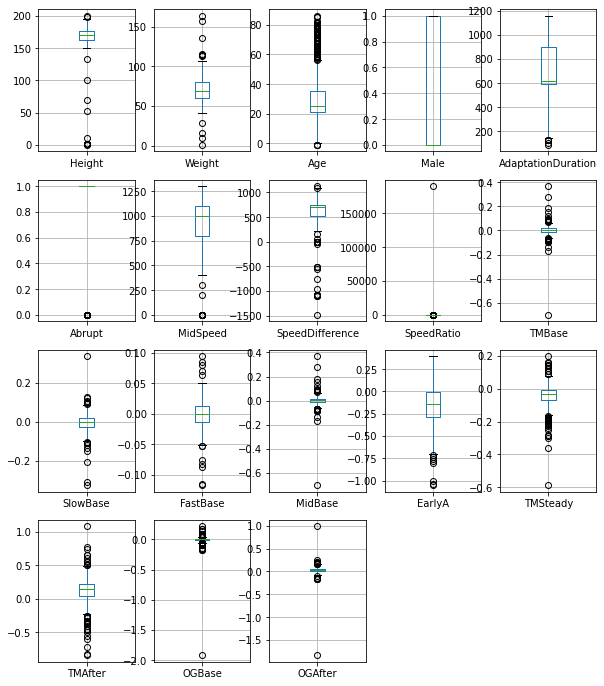

In [5]:
Measures2Check=["Height", "Weight", "Age", "Male", "AdaptationDuration",\
               "Abrupt", "MidSpeed", "SpeedDifference", "SpeedRatio", \
               "TMBase", "SlowBase", "FastBase", "MidBase", "EarlyA",\
               "TMSteady", "TMAfter", "OGBase", "OGAfter"]


def CheckingBoxWhiskers(Inputs='Height'):
    nrows=math.ceil(len(Inputs)/5)
    plt.figure(figsize=(10, 12))
    for i in range(len(Inputs)):
        plt.subplot(nrows, 5, i+1)
        hist = df.boxplot(column=Inputs[i])
    plt.show()
    
CheckingBoxWhiskers(Measures2Check)  

Data Cleaning
---

I am going to create a clean copy of the data file to work with in future notebooks

In [6]:
import pandas as pd
import numpy as np # Data cleaning and manipulaitons

Prior to creating a 'clean' dataframe, I am going to make a few corrections. Due to data collection difference some of these measures may have the wrong "sign" so I will correct that here.

In [7]:
df["SpeedDifference"]=abs(df["SpeedDifference"])
df["SpeedRatio"]=abs(df["SpeedRatio"])
df["MidSpeed"]=abs(df["MidSpeed"])

In [8]:
# Make a COPY of my data for cleaning
dfClean=df.copy()

# Missing Data

I don't want to drop all rows with NaNs because there are experiemental reasons why there may be Nans.  Rather, I am only going to remove rows of data where 'essential' data is missing.

In [9]:
badIndex=(np.isnan(df.TMSteady)) | (np.isnan(df.SpeedDifference)) | (np.isnan(df.SpeedRatio)) |\
(np.isnan(df.EarlyA)) | (np.isnan(df.TMBase)) | (np.isnan(df.Age)) |\
(np.isnan(df.AdaptationDuration)) | (abs(df.SpeedRatio)>3) | (df.Age<18) |\
((df.SpeedRatio != 2) & (df.SpeedRatio != 3))

dfClean = dfClean.drop(dfClean[badIndex].index)

dfClean.shape

(536, 31)

### Note to self -- Who are these people with missing data, can I recover this data?

#df.loc[badIndex, "ID"]

#df.loc[df.Age<18, "ID"]

#df.loc[abs(df.SpeedRatio)>3, "ID"]

#df.loc[abs(df.SpeedRatio)<2, "ID"]

# Protocol Details

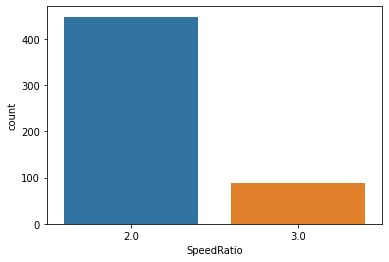

In [10]:
sns.countplot(x="SpeedRatio", data=dfClean)
plt.show()

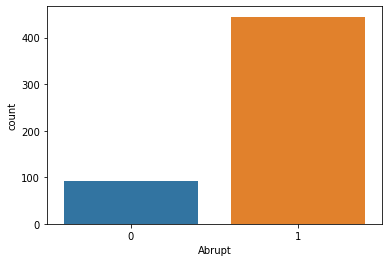

In [11]:
sns.countplot(x="Abrupt", data=dfClean)
plt.show()

<Figure size 720x864 with 0 Axes>

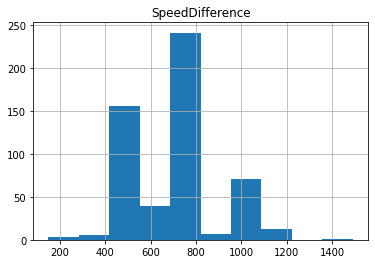

In [12]:
plt.figure(figsize=(10, 12))
dfClean.hist('SpeedDifference')
plt.show()

<Figure size 720x864 with 0 Axes>

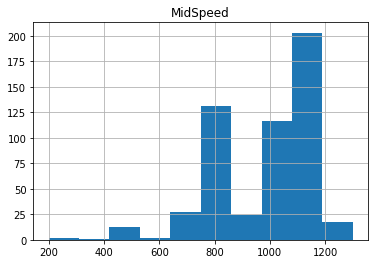

In [13]:
plt.figure(figsize=(10, 12))
dfClean.hist('MidSpeed')
plt.show()

<Figure size 720x864 with 0 Axes>

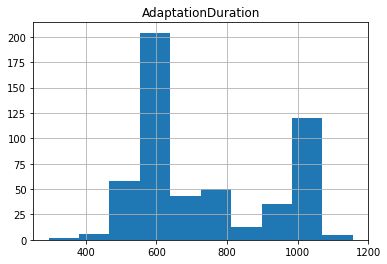

In [14]:
plt.figure(figsize=(10, 12))
dfClean.hist('AdaptationDuration')
plt.show()

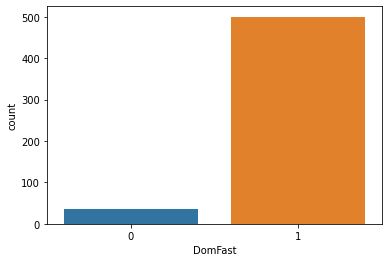

In [15]:
dfClean["DomFast"] = 1*(dfClean["RightLeg_Dom"] == dfClean["RightLeg_Fast"])

sns.countplot(x="DomFast", data=dfClean)
plt.show()

# Subject Demographics

### Cleaning Height & Weight and Calculating BMI

Based on the initial visualization of height and weight it is clear that there are some issues with height and weight.  First, there are missing values, second some values seem to be in the wrong units whereas others are not realistic.  The current strategy is to correct units, replace unrealistic values with mean, and then calculate BMI.

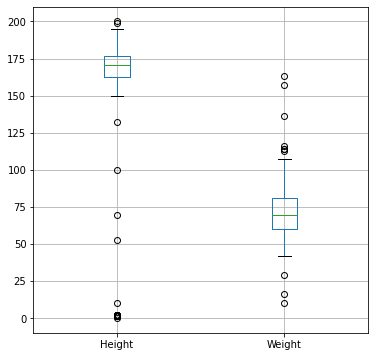

In [16]:
dfClean[{"Height", "Weight"}].boxplot(figsize = (6, 6));
plt.show()

In [17]:
# Clearn Weights

# Calculate what the mean resonable height is
NormalWeight = dfClean.loc[dfClean["Weight"]>30,'Height'].index
NormalWeightMean = dfClean.loc[NormalWeight,'Weight'].mean()

# Replace unresonable weights with the mean
WrongWeight = dfClean.loc[dfClean["Weight"]<30,'Weight'].index
dfClean.at[WrongWeight,'Weight'] = NormalWeightMean


In [18]:
#Clean Heights

# Convert Heights in meters to centimeters for consistency
MeterHeight = dfClean.loc[dfClean["Height"]<2,'Height'].index
dfClean.at[MeterHeight,'Height'] = 100 * dfClean.loc[dfClean["Height"]<2, "Height"]

# Calculate what the mean resonable height is
NormalHeight = dfClean.loc[dfClean["Height"]>122,'Height'].index
NormalHeightMean = dfClean.loc[NormalHeight,'Height'].mean()

# Replace unresonable weights with the mean
WrongHeight = dfClean.loc[dfClean["Height"]<122,'Height'].index
dfClean.at[WrongHeight,'Height'] = NormalHeightMean


In [19]:
# Assuming that all subjects who are missing height are also missing weight
dfClean["Height"] = dfClean["Height"].fillna(dfClean["Height"].mean())
dfClean["Weight"] = dfClean["Weight"].fillna(dfClean["Weight"].mean())

In [20]:
# Convert confirmed weights in pounds to killograms
dfClean.at[dfClean["ID"]=="CG09_NewProKin", "Weight"]=61.7
dfClean.at[dfClean["ID"]=="Forget17", "Weight"]=71.2

In [21]:
# Finally, calculate BMI
dfClean["BMI"] = (dfClean["Weight"]/(dfClean["Height"]/100)**2)
dfClean.loc[dfClean["BMI"]>40, ["Height", "Weight", "BMI"]]

,Height,Weight,BMI
52,162.2,114.0,43.331443
331,183.5,163.4,48.526606


The BMI is still very high for some of the subjects, but these are consistent with self reported heights and weights.

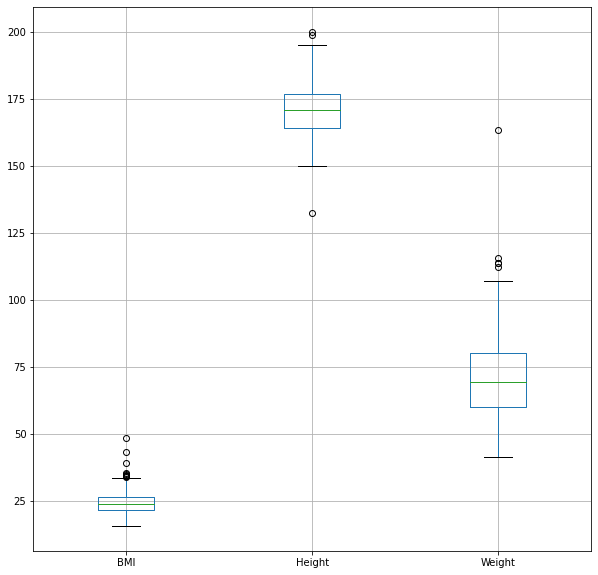

In [22]:
dfClean[{"Height", "Weight", "BMI"}].boxplot(figsize = (10, 10));
plt.show()

### Cleaning Age and adding a Discretized Age

<Figure size 720x864 with 0 Axes>

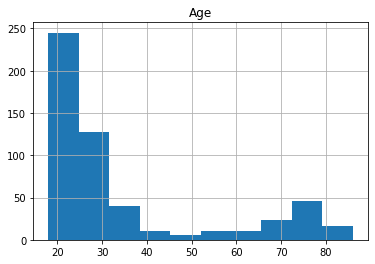

In [23]:
plt.figure(figsize=(10, 12))
dfClean.hist('Age')
plt.show()

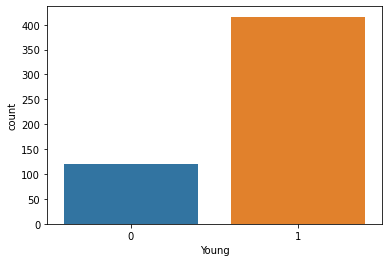

In [24]:
dfClean["Young"]=1*(dfClean["Age"]<40)

sns.countplot(x="Young", data=dfClean)
plt.show()

### Clincial Features

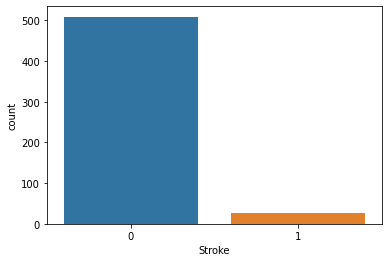

In [25]:
sns.countplot(x="Stroke", data=dfClean)
plt.show()

Gait Training Outcome Measures
---

Given that we know 0.04 is a clinically signfiicant magnitude of step length asymmetry threshold and that this roughly corresponds to the 50% percentile of steady states (see below) I am using this a somewhat arbitrary threshold for "good" vs. "bad" steady states.

In other words  I am framining this as a classification problem.  Specifically, I am classifying those that get basically to symmetric stepping or overshot symmetry (i.e., Steady State > -0.04 -- which would be energetically optimal, but this level of optimization is usually not possible for the duration of a single session).

<Figure size 720x864 with 0 Axes>

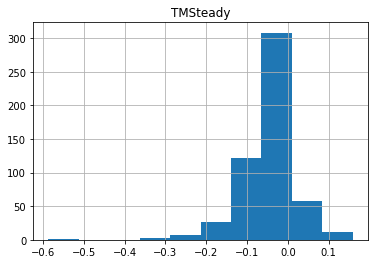

In [26]:
plt.figure(figsize=(10, 12))
dfClean.hist('TMSteady')
plt.show()

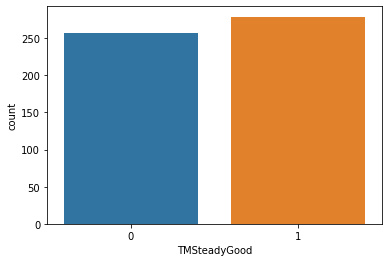

In [27]:
dfClean["TMSteadyGood"]=1*(dfClean["TMSteady"]> -0.04)

sns.countplot(x="TMSteadyGood", data=dfClean)
plt.show()

After-effects are another measure that we would like to use both for regression and classificaiton. Again, a clinciall signficiant change in step length asymmetry will be defined with 0.04 based on previous literature. Thus After-Effects greater than or equal to 0.04 during adaptaiton will indicated 'sucessful' training.

<Figure size 720x864 with 0 Axes>

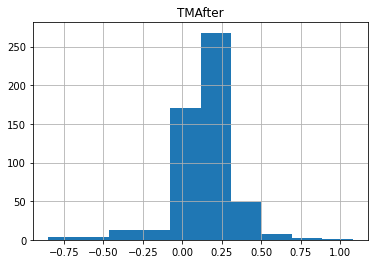

In [28]:
plt.figure(figsize=(10, 12))
dfClean.hist('TMAfter')
plt.show()

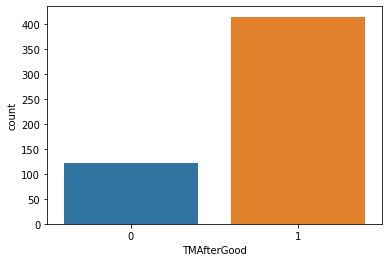

In [29]:
dfClean["TMAfterGood"]=1*(dfClean["TMAfter"]> 0.04)

sns.countplot(x="TMAfterGood", data=dfClean)
plt.show()

DetlaAdaptation is another measure that we would like to use both for regression and classificaiton.  Again, a clinciall signficiant change in step length asymmetry will be defined with 0.04 based on previous literature. Thus a change of step length asymemtry of greater than or equal to 0.04 during adaptaiton will indicated 'good' adaptation. 

A potential problem with this outcome measure as a whole is that it is sensitive to wether a gradual or abrupt protocol is used.

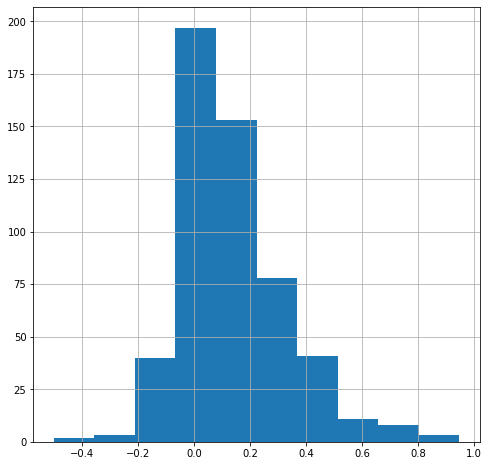

In [30]:
dfClean["DeltaAda"]= dfClean["TMSteady"] - dfClean["EarlyA"]
dfClean["DeltaAda"].hist(figsize = (8, 8));
plt.show()

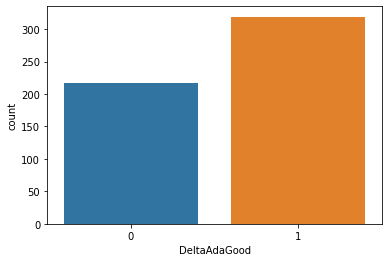

In [31]:
dfClean["DeltaAdaGood"]=1*(dfClean["DeltaAda"]> 0.04)
sns.countplot(x="DeltaAdaGood", data=dfClean)
plt.show()

Transforming Explortation
---

In [32]:
Measures2Check=["Height", "Weight", "Age", "AdaptationDuration",\
                "MidSpeed", "SpeedDifference", "TMBase", \
                "EarlyA", "BMI"]

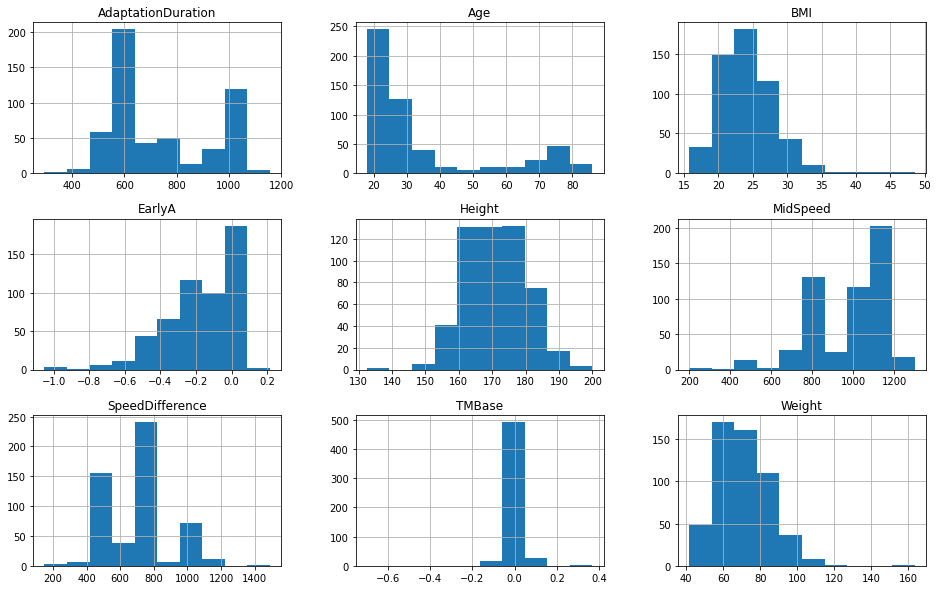

In [33]:
dfClean[Measures2Check].hist(figsize = (16, 10));
plt.show()

There are several features which seem normally distributed:
- BMI
- Height
- Weight
- MidBase/TMbase

There are a few features which are multi-modal and/or skewed:
- Adaptation Duration
- Age
- EarlyA
- MidSpeed
- SpeedDifference


In [34]:
import numpy as np
NotNormalAndPositive=["AdaptationDuration", "MidSpeed", "SpeedDifference", "Age"]# "EarlyA"
#np.log(dfClean[NotNormalAndPositive]).hist(figsize = (16, 10))
#np.sqrt(dfClean[NotNormalAndPositive]).hist(figsize = (16, 10)) # works for mid speed
#np.cbrt(dfClean[NotNormalAndPositive]).hist(figsize = (16, 10)) # works for SpeedDifference
#plt.show()

A Quantile Transformation is used beause more traditional transformations (log, square-root, and cube-root) were not sucessful at normalizaing the data.

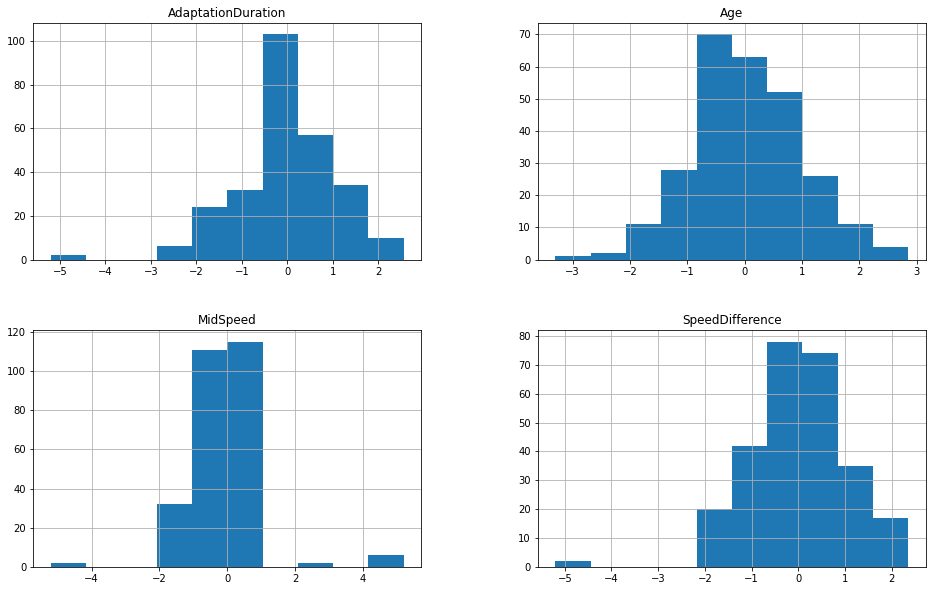

In [35]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

qt = QuantileTransformer(n_quantiles=100, output_distribution='normal',
                         random_state=RSEED)

X_train, X_test = train_test_split(dfClean[NotNormalAndPositive], test_size=.5)

X_trans_qt = qt.fit(X_train).transform(X_test)
TransformedFeatures = pd.DataFrame(X_trans_qt, columns = NotNormalAndPositive)
TransformedFeatures.hist(figsize = (16, 10))
plt.show()


In [36]:
dfTransformed=dfClean.copy()
dfTransformed[NotNormalAndPositive] = TransformedFeatures

Scaling Explortation
---

In [37]:
Measures2Check=["Height", "Weight", "Age", "Male", "RightLeg_Fast", "AdaptationDuration",\
                "Abrupt", "MidSpeed", "SpeedDifference", "SpeedRatio", 'IsCatch', 'Stroke',\
                "MidBase", "EarlyA","BMI", "Young", "TMSteadyGood", "TMAfterGood", "DeltaAdaGood"]

In [38]:
from sklearn import preprocessing


mm_scaler = preprocessing.MinMaxScaler()
dfTransformedScaled = pd.DataFrame(mm_scaler.fit_transform(dfTransformed[Measures2Check]), columns = Measures2Check)

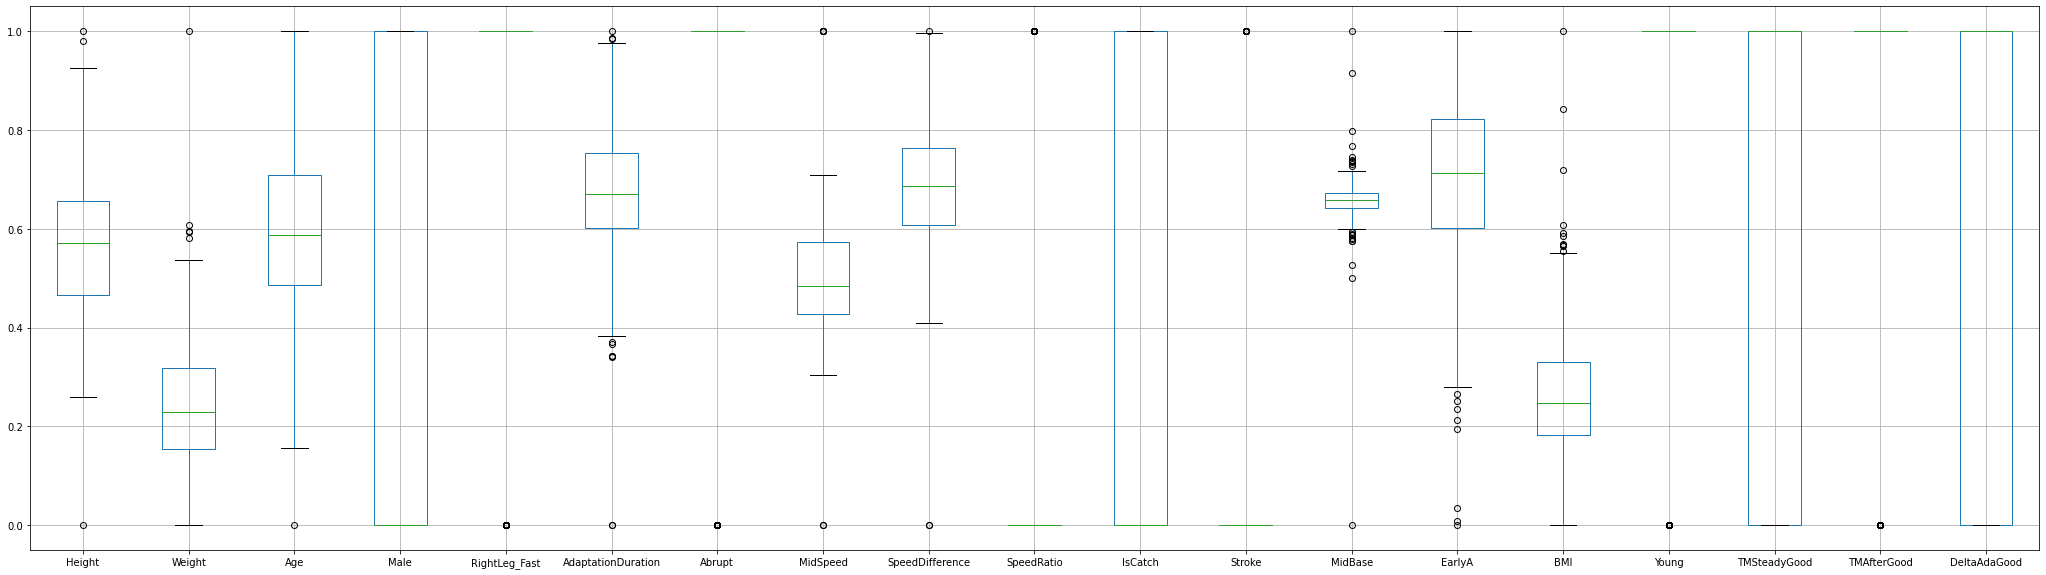

In [39]:
dfTransformedScaled[Measures2Check].boxplot(figsize = (36, 10));
plt.show()

Presumably I will want to save the cleaned data....
---

In [40]:
dfClean.to_csv('CleanDataBase.csv', index=False)

In [41]:
dfTransformedScaled.to_csv('TransformedScaledDataBase.csv', index=False)